# Fall Alamo Float Comparisons (2016-2017)

In [11]:
%matplotlib inline

import datetime

import pandas as pd
from netCDF4 import Dataset

import urllib

import cmocean

In [12]:
### using code from https://ioos.github.io/notebooks_demos/notebooks/2017-03-21-ERDDAP_IOOS_Sensor_Map/
import requests
try:
    from urllib.parse import urlencode
except ImportError:
    from urllib import urlencode


def encode_erddap(urlbase, fname, columns, params):
    """
    urlbase: the base string for the endpoint
             (e.g.: https://erddap.axiomdatascience.com/erddap/tabledap).
    fname: the data source (e.g.: `sensor_service`) and the response (e.g.: `.csvp` for CSV).
    columns: the columns of the return table.
    params: the parameters for the query.

    Returns a valid ERDDAP endpoint.
    """
    urlbase = urlbase.rstrip('/')
    if not urlbase.lower().startswith(('http:', 'https:')):
        msg = 'Expected valid URL but got {}'.format
        raise ValueError(msg(urlbase))

    columns = ','.join(columns)
    params = urlencode(params)
    endpoint = '{urlbase}/{fname}?{columns}&{params}'.format

    url = endpoint(urlbase=urlbase, fname=fname,
                   columns=columns, params=params)
    r = requests.get(url)
    r.raise_for_status()
    return url

## Set parameters    
Set the parameters below to retrieve all data after the specified date with pressure values between 0.5m and 35m

In [13]:
try:
    from urllib.parse import unquote
except ImportError:
    from urllib2 import unquote

# return profile for float id
def get_profile(alamo_id,starttime,endtime):
    
    urlbase = 'http://ferret.pmel.noaa.gov/alamo/erddap/tabledap'

    fname = 'arctic_heat_alamo_profiles_'+str(alamo_id)+'.csvp'

    columns = ('profileid',
               'FLOAT_SERIAL_NO',
               'CYCLE_NUMBER',
               'REFERENCE_DATE_TIME',
               'JULD',
               'time',
               'latitude',
               'longitude',
               'PRES',
               'TEMP',
               'PSAL')
    params = {
        # Inequalities do not exist in HTTP parameters,
        # so we need to hardcode the `>` in the time key to get a '>='.
        # Note that a '>' or '<' cannot be encoded with `urlencode`, only `>=` and `<=`.
        'time>': starttime+'T00:00:00Z',
        'time<': endtime+'T00:00:00Z',
        'PRES>': 0.5,
        'PRES<': 35,
    }

    url = encode_erddap(urlbase, fname, columns, params)

    df = pd.read_csv(url, index_col=0, parse_dates=['time (UTC)'])
    
    return df

In [21]:
af_9119 = get_profile(9119,'2017-08-01','2017-12-01')
af_9085 = get_profile(9085,'2016-08-01','2016-12-01')
af_9076 = get_profile(9076,'2016-08-01','2016-12-01')

In [22]:
af_9119gbc = af_9119.groupby('CYCLE_NUMBER').mean()
af_9085gbc = af_9085.groupby('CYCLE_NUMBER').mean()
af_9076gbc = af_9076.groupby('CYCLE_NUMBER').mean()

In [23]:
af_9076gbc.keys()

Index([u'FLOAT_SERIAL_NO', u'REFERENCE_DATE_TIME', u'JULD (UTC)',
       u'latitude (degrees_north)', u'longitude (degrees_east)',
       u'PRES (decibar)', u'TEMP (degree_Celsius)', u'PSAL (PSU)'],
      dtype='object')

In [24]:
af_9076['time (UTC)'][0].to_pydatetime().timetuple().tm_yday

260

### Map via Cartopy

In [25]:
#using Cartopy for mapping
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def erddap_etopo1():
    """get subset of etopo1 data from erddap"""
    
    urllib.urlretrieve("http://coastwatch.pfeg.noaa.gov/erddap/griddap/etopo180.nc?altitude[(65):1:(75)][(-170):1:(-155)]","data/etopo1_tmp.nc")
    
def etopo1_subset(file='etopo1.nc', region=None):
    """ read in ardemV2 topography/bathymetry. """
    
    bathydata = Dataset(file)
    
    topoin = bathydata.variables['altitude'][:]
    lons = bathydata.variables['longitude'][:]
    lats = bathydata.variables['latitude'][:]
    bathydata.close()
    
    return(topoin, lats, lons)

def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(13, 8),
                           subplot_kw=dict(projection=projection))
    if projection == ccrs.PlateCarree():
        gl = ax.gridlines(draw_labels=True)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='1.0')


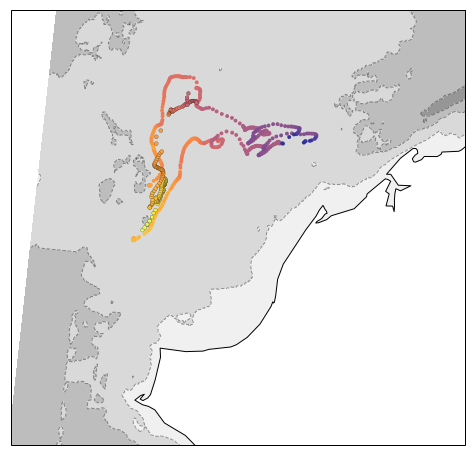

In [26]:
### Region Wide
extent = [-170, -158, 68, 72]
erddap_etopo1()
(topoin, lats, lons) = etopo1_subset(file='data/etopo1_tmp.nc')

projection=ccrs.LambertConformal(central_longitude=-160.0)
transformation=ccrs.PlateCarree()
fig,ax = make_map(projection=projection)

## Scatter plot of integrated temp
ax.scatter([af_9076gbc['longitude (degrees_east)']],[af_9076gbc['latitude (degrees_north)']],
        15, c=[af_9076gbc['TEMP (degree_Celsius)']], linewidth=0, edgecolors='none', marker='o', vmin=-2, vmax=7,
        cmap=cmocean.cm.thermal, transform=transformation, zorder=3
        )
ax.scatter([af_9085gbc['longitude (degrees_east)']],[af_9085gbc['latitude (degrees_north)']],
        15, c=[af_9085gbc['TEMP (degree_Celsius)']], linewidth=0, edgecolors='none', marker='o', vmin=-2, vmax=7,
        cmap=cmocean.cm.thermal, transform=transformation, zorder=3
        )
ax.scatter([af_9119gbc['longitude (degrees_east)']],[af_9119gbc['latitude (degrees_north)']],
        15, c=[af_9119gbc['TEMP (degree_Celsius)']], linewidth=0.2, edgecolors='k', marker='o', vmin=-2, vmax=7,
        cmap=cmocean.cm.thermal, transform=transformation, zorder=3
        )
## bathymetry contours
CS = plt.contour(lons, lats, topoin, [-1000, -100, -50, -25,], 
                 colors='k', alpha=0.4, linestyle='--', linewidths=1, zorder=2,
                 transform=transformation)
CS = plt.contourf(lons, lats, topoin, [-1000, -100, -50, -25,], 
                 colors=('#737373','#969696','#bdbdbd','#d9d9d9','#f0f0f0'), extend='both', zorder=1,
                 transform=transformation)

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)

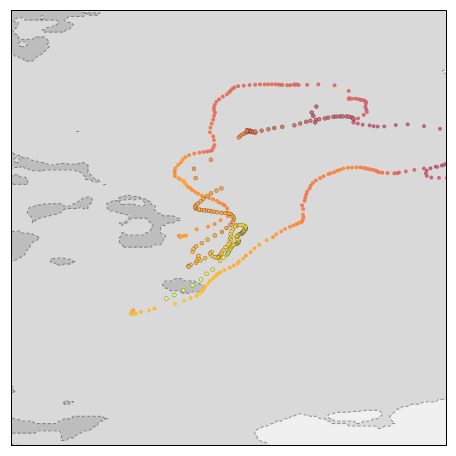

In [27]:
### Zoomed
extent = [-168, -165, 69, 72]
erddap_etopo1()
(topoin, lats, lons) = etopo1_subset(file='data/etopo1_tmp.nc')

fig,ax = make_map(projection=ccrs.PlateCarree(-160))

ax.scatter([af_9076gbc['longitude (degrees_east)']],[af_9076gbc['latitude (degrees_north)']],
        15, c=[af_9076gbc['TEMP (degree_Celsius)']], linewidth=0, edgecolors='none', marker='o', vmin=-2, vmax=7,
        cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), zorder=3
        )
ax.scatter([af_9085gbc['longitude (degrees_east)']],[af_9085gbc['latitude (degrees_north)']],
        15, c=[af_9085gbc['TEMP (degree_Celsius)']], linewidth=0, edgecolors='none', marker='o', vmin=-2, vmax=7,
        cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), zorder=3
        )
ax.scatter([af_9119gbc['longitude (degrees_east)']],[af_9119gbc['latitude (degrees_north)']],
        15, c=[af_9119gbc['TEMP (degree_Celsius)']], linewidth=0.2, edgecolors='k', marker='o', vmin=-2, vmax=7,
        cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree(), zorder=3
        )
## bathymetry contours
CS = plt.contour(lons, lats, topoin, [-1000, -100, -50, -25,], 
                 colors='k', alpha=0.4, linestyle='--', linewidths=1, zorder=2,
                 transform=ccrs.PlateCarree())
CS = plt.contourf(lons, lats, topoin, [-1000, -100, -50, -25,], 
                 colors=('#737373','#969696','#bdbdbd','#d9d9d9','#f0f0f0'), extend='both', zorder=1,
                 transform=ccrs.PlateCarree())

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent(extent)